# Черновик по квантизации

In [ ]:
!git clone https://github.com/chuanyangjin/fast-DiT.git

Cloning into 'fast-DiT'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 67 (delta 31), reused 60 (delta 26), pack-reused 0
Receiving objects: 100% (67/67), 6.37 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion #функция из гитхаба
from diffusers.models import AutoencoderKL
from download import find_model  #функция из гитхаба
from models import DiT_XL_2  #функция из гитхаба
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00


In [ ]:
image_size = 256 #собакаparam [256, 512]
# vae_model = "stabilityai/sd-vae-ft-ema" #собакаparam ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

In [ ]:
model = DiT_XL_2(input_size=latent_size).to(device)

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/q_dit_xl_256.pt /content/

In [ ]:
# есть свои веса
image_size = 256
state_dict = find_model(f"/content/q_dit_xl_256.pt")

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:314: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [ ]:
# #если нет своих весов
# image_size = 256
# state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")

In [ ]:
model.load_state_dict(state_dict)
# model.eval() # important!

RuntimeError: ignored

In [ ]:
from torch import nn

In [ ]:
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)


In [ ]:
quantized_model

DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): DynamicQuantizedLinear(in_features=256, out_features=1152, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): SiLU()
      (2): DynamicQuantizedLinear(in_features=1152, out_features=1152, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 1152)
  )
  (blocks): ModuleList(
    (0-27): 28 x DiTBlock(
      (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): DynamicQuantizedLinear(in_features=1152, out_features=3456, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): DynamicQuantizedLinear(in_features=1152, out_features=1152, dtype=to

In [ ]:
import os

# save the model and check the model size
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

In [ ]:
f=print_size_of_model(model,"fp32")

model:  fp32  	 Size (MB): 2700.611783


In [ ]:
q=print_size_of_model(quantized_model,"int8")

model:  int8  	 Size (MB): 681.198439


In [ ]:
print("{0:.2f} times smaller".format(2700611783/q))

3.96 times smaller


In [ ]:
vae_model = "stabilityai/sd-vae-ft-ema"
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
device2 = 'cpu'

In [ ]:
# quantized_model.to(device2)

In [ ]:
# quantized_model.eval()

In [ ]:
quantized_model = quantized_model.cuda()

In [ ]:
quantized_model.eval()

DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): DynamicQuantizedLinear(in_features=256, out_features=1152, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): SiLU()
      (2): DynamicQuantizedLinear(in_features=1152, out_features=1152, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 1152)
  )
  (blocks): ModuleList(
    (0-27): 28 x DiTBlock(
      (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): DynamicQuantizedLinear(in_features=1152, out_features=3456, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): DynamicQuantizedLinear(in_features=1152, out_features=1152, dtype=to

In [ ]:
# Конвертирование обратно в формат с плавающей запятой (FP32)
quantized_model = quantized_model.to(torch.float32)

# Отправка на устройство CUDA
device = torch.device("cuda")
quantized_model = quantized_model.to(device)


In [ ]:
seed = 0 #собparam {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 100 #собparam {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #собparam {type:"slider", min:1, max:10, step:0.1}
class_labels = 0, #собparam {type:"raw"}
samples_per_row = 4 #собparam {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)


samples = diffusion.p_sample_loop(
    # Generate samples from the model
    quantized_model.forward_with_cfg, z.shape, z, clip_denoised=False,
 #   '''
 #   # model.forward_with_cfg:
 #   Forward pass of DiT, but also batches the unconditional forward
 #   pass for classifier-free guidance.

 #   # z.shape
 #   torch.Size([8, 4, 32, 32])
  #  '''
    model_kwargs=model_kwargs, progress=True, device=device
)

samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

  0%|          | 0/100 [00:00<?, ?it/s]

NotImplementedError: ignored

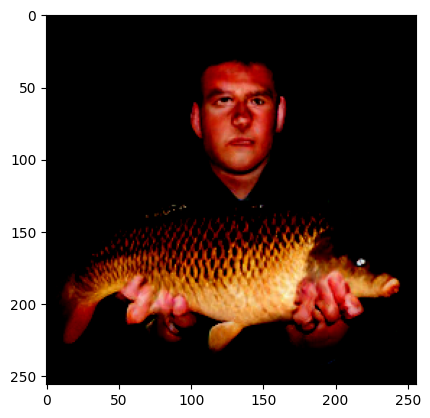

In [ ]:
#квантизованная модель 780мб
import matplotlib.pyplot as plt
plt.imshow(samples_res[0].permute(1, 2, 0).cpu().detach())

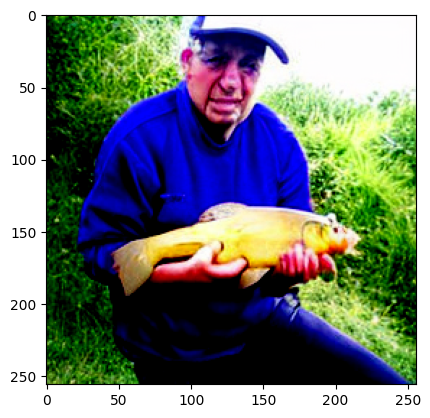

In [ ]:
#обычная модель 2600 мб
import matplotlib.pyplot as plt
plt.imshow(samples_res[0].permute(1, 2, 0).cpu().detach())

### Пример из документации torch

In [ ]:
import torch
import torch.quantization
import torch.nn as nn

In [ ]:
torch.manual_seed(0)  # set the seed for reproducibility

class SampleLSTM(nn.Module):
  """Sample lstm model"""

  def __init__(self,in_dim,out_dim,depth):
     super(SampleLSTM,self).__init__()
     self.lstm = nn.LSTM(in_dim,out_dim,depth)

  def forward(self,inputs,hidden):
     out,hidden = self.lstm(inputs,hidden)
     return out, hidden


#shape parameters
model_dimension=20
sequence_length=10
batch_size=1
lstm_depth=1

# random data for input
inputs = torch.randn(sequence_length,batch_size,model_dimension)
# hidden is actually is a tuple of the initial hidden state and the initial cell state
hidden = (torch.randn(lstm_depth,batch_size,model_dimension), torch.randn(lstm_depth,batch_size,model_dimension))

In [ ]:
# here is our floating point instance
original_lstm = SampleLSTM(model_dimension, model_dimension, lstm_depth)

In [ ]:
model.blocks.3.mlp.fc2.bias

SyntaxError: ignored

In [ ]:
model.final_layer

FinalLayer(
  (norm_final): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
  (linear): Linear(in_features=1152, out_features=32, bias=True)
  (adaLN_modulation): Sequential(
    (0): SiLU()
    (1): Linear(in_features=1152, out_features=2304, bias=True)
  )
)

In [ ]:
list(model.state_dict().keys())

['pos_embed',
 'x_embedder.proj.weight',
 'x_embedder.proj.bias',
 't_embedder.mlp.0.weight',
 't_embedder.mlp.0.bias',
 't_embedder.mlp.2.weight',
 't_embedder.mlp.2.bias',
 'y_embedder.embedding_table.weight',
 'blocks.0.attn.qkv.weight',
 'blocks.0.attn.qkv.bias',
 'blocks.0.attn.proj.weight',
 'blocks.0.attn.proj.bias',
 'blocks.0.mlp.fc1.weight',
 'blocks.0.mlp.fc1.bias',
 'blocks.0.mlp.fc2.weight',
 'blocks.0.mlp.fc2.bias',
 'blocks.0.adaLN_modulation.1.weight',
 'blocks.0.adaLN_modulation.1.bias',
 'blocks.1.attn.qkv.weight',
 'blocks.1.attn.qkv.bias',
 'blocks.1.attn.proj.weight',
 'blocks.1.attn.proj.bias',
 'blocks.1.mlp.fc1.weight',
 'blocks.1.mlp.fc1.bias',
 'blocks.1.mlp.fc2.weight',
 'blocks.1.mlp.fc2.bias',
 'blocks.1.adaLN_modulation.1.weight',
 'blocks.1.adaLN_modulation.1.bias',
 'blocks.2.attn.qkv.weight',
 'blocks.2.attn.qkv.bias',
 'blocks.2.attn.proj.weight',
 'blocks.2.attn.proj.bias',
 'blocks.2.mlp.fc1.weight',
 'blocks.2.mlp.fc1.bias',
 'blocks.2.mlp.fc2.weigh

In [ ]:
list(original_lstm.state_dict().keys())

['lstm.weight_ih_l0',
 'lstm.weight_hh_l0',
 'lstm.bias_ih_l0',
 'lstm.bias_hh_l0']

In [ ]:
original_lstm.lstm.weight_hh_l0

Parameter containing:
tensor([[-0.1432, -0.1142,  0.0336,  ..., -0.1142, -0.0200, -0.0279],
        [-0.2113,  0.1516, -0.0226,  ...,  0.1554, -0.0017,  0.0686],
        [ 0.0078,  0.0061, -0.2128,  ...,  0.0872,  0.0518,  0.2074],
        ...,
        [ 0.0623,  0.0426, -0.1069,  ...,  0.1204,  0.0552, -0.0466],
        [-0.1422,  0.1912, -0.1448,  ..., -0.1343, -0.0965, -0.1382],
        [-0.0388,  0.0801, -0.1810,  ..., -0.2228, -0.1998, -0.2007]],
       requires_grad=True)

In [ ]:
original_lstm

SampleLSTM(
  (lstm): LSTM(20, 20)
)

In [ ]:
quantized_lstm = torch.quantization.quantize_dynamic(
    original_lstm, {original_lstm.lstm.weight_ih_l0}, dtype=torch.qint8
)

In [ ]:
# here is our floating point instance
original_lstm = SampleLSTM(model_dimension, model_dimension, lstm_depth)

# apply quantization on the model
quantized_lstm = torch.quantization.quantize_dynamic(
    original_lstm, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

# show the changes that were made
print('Original model:')
print(original_lstm)
print('')
print('Quantized model:')
print(quantized_lstm)

Original model:
SampleLSTM(
  (lstm): LSTM(20, 20)
)

Quantized model:
SampleLSTM(
  (lstm): DynamicQuantizedLSTM(20, 20)
)


In [ ]:
import os

# save the model and check the model size
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

In [ ]:
f=print_size_of_model(original_lstm,"fp32")
q=print_size_of_model(quantized_lstm,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 14.797
model:  int8  	 Size (KB): 5.645
2.62 times smaller


# Черновик по прунингу

In [ ]:
from models import DiT_XL_2
from download import find_model

In [ ]:

image_size = 256 #собакаparam [256, 512]
# vae_model = "stabilityai/sd-vae-ft-ema" #собакаparam ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

In [ ]:
# Load model:
# уже заполняет память

model = DiT_XL_2(input_size=latent_size)

In [ ]:
#бращается к папке DiT если нет весов, то скачивает их c сервера фб
# https://dl.fbaipublicfiles.com/DiT/models/{model_name}

state_dict = find_model(f"/content/DiT-XL-2-256x256.pt")

In [ ]:
#загрузка весов внутрь модели
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model = model.to('cuda')

In [ ]:
# Этот код применяет L1-прунинг (pruning) к каждому слою nn.Conv2d и nn.Linear в модели,
# сохраняя указанный процент ненулевых весов (в данном примере, 50% ненулевых весов).
# Затем вызывается prune.remove, чтобы удалить нулевые веса и уменьшить размер модели.

# Определите процент прунинга (например, 50%)
pruning_perc = 60

# Примените прунинг к модели
for module in model.modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=pruning_perc/100.0)

        prune.remove(module, "weight")


In [ ]:
torch.save(model.state_dict(), 'prune_w2')